### HMM EXERCISE 2 


In [1]:
# check the environment and add installs as needed
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

try:
    import pyspch
except:
    ! pip install git+https://github.com/compi1234/pyspch.git
    import pyspch

In [2]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
from sklearn import preprocessing

from pyspch import Densities
import pyspch.libhmm as libhmm
import pyspch.utils as Spchu

In [3]:
# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
pd.reset_option('display.float_format')
pd.set_option('precision',3)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

In [4]:
# CODE BLOCK WITH EXTENSIONS TO THE libhmm.HMM class
#
# - training routine .fit()
# - recognition routine .recognize()
# - score routine .predict_proba()
#
class hmm_x(libhmm.HMM):
    
    def fit(self,X,y):
        '''
        fit() takes a list of example observations X and a list of example alignments y
        that should coming in matching sequence
        '''
        # training of the observation probabilities
        self.obs_model.fit(np.concatenate(X),np.concatenate(y))
            
        # train initial and transition probabilities
        init_counts = np.zeros(self.n_states,dtype='float')
        trans_counts = np.zeros((self.n_states,self.n_states),dtype='float')         
        for (Xi,yi) in zip(X,y):
            init_counts[yi[0]] += 1.
            for j in range(1,Xi.shape[0]):
                trans_counts[ yi[j-1],yi[j] ] += 1.
        self.transmat = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
        self.initmat = init_counts / np.sum(init_counts)
        if self.prob_style == "log":
            self.transmat = Spchu.logf(self.transmat)
            self.initmat = Spchu.logf(self.initmat)

                    
    # find the HMM likelihood score for input sequences for the best admissible end_states
    def predict_proba(self,X=None,method='Viterbi',end_states=None):
        results = np.array([])
        for Xi in X:
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            seq_prob,_ = trellis.finalize(end_states=end_states)
            results = np.append(results,seq_prob)
        return results

    # find the HMM likelihood score for input sequences for all admissible end_states
    def recognize(self,X=None,method='Viterbi',end_states=None,Print=True):
        if end_states is None: end_states = self.end_states
        results = []
        for Xi in X:
            results_i = []
            trellis = libhmm.Trellis(self)
            if method == "Viterbi":
                trellis.viterbi_pass(Xi)
            else:
                trellis.forward_pass(Xi)
            for end_state in end_states:
                seq_prob,_ = trellis.finalize(end_states=[end_state])
                results_i.append((end_state,seq_prob))
            results.append(results_i)
        if(Print):
            for i in range(len(results)):
                print("\n== Sample (%d) === " %i)
                for res in results[i]:
                    (end_s,score) = res
                    print('Endstate=%s, score=%.2e' % (self.states[end_s],score) )
        return results

In [5]:
# CODE BLOCK FOR GENERATING DEFAULT TEST SAMPLES
#
# first define the phone set and make a hashing index to map labels to index
phones = np.array(["M","IY","Y","UW"])
ph2indx = dict( zip(phones, range(0,len(phones))) )
#
# Example Data for "me" and "you"
#
X_ME = [
 np.array([4.0,2.5,1.0,2.0,5.0,8.0]).reshape(-1,1), 
 np.array([4.5,2.0,1.0,1.5,6.5,7.0]).reshape(-1,1), 
 np.array([3.5,2.5,1.5,3.0,7.0]).reshape(-1,1)
]
ph_ME = [
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY","IY"]),
    np.array(["M","M","M","IY","IY"]) 
]

X_YOU = [
 np.array([1.0,2.0,4.5,8.0,6.5,1.5]).reshape(-1,1), 
 np.array([1.5,2.5,4.0,7.0,3.0]).reshape(-1,1), 
 np.array([1.0,2.5,3.5,7.0,5.0,2.0]).reshape(-1,1)
]
ph_YOU = [
 np.array([ "Y","Y","Y","UW","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW"]),
 np.array([ "Y","Y","Y","UW","UW","UW"]) 
]
ph_list = ph_ME + ph_YOU
X_list = X_ME + X_YOU

### 
# map phone-labels to indices for all alignments
y_list = [ np.array( [ ph2indx[x] for x in ph ]) for ph in ph_list ] 

## a test utterance
X_test = [np.array([1.2, 3.1, 4.8, 7.6, 4.3]).reshape(-1,1),
        np.array([3.1, 2.5, 2.0, 2.0, 2.0,  4.6, 4.9, 5.2, 5.4]).reshape(-1,1) ] 

In [6]:
# CODE BLOCK FOR FEATURE TRANSFORMATIONS
#
# padding copies the edge frames N times 
# e.g.   padding sequence [a,b,c,d] with 2 frames will result in 
#                     [a,a,a,b,c,d,d,d]
def pad_time(X,N = 1):
    X_padded = np.pad(X,[(N,N),(0,0)],mode='edge')
    return X_padded

# deltas are computed as first order difference: 
# delta_x(t) = x(t+1) - x(t-1) 
def deltas(X):
    X_p = pad_time(X,N=1)
    delta_X = X_p[2:,:] - X_p[0:-2,:]
    return delta_X

# splice 2*Ns+1 frames , i.e. add Ns frames on left and right side
# to the current feature vector
def splice(X,N=1):
    X_p = pad_time(X,N=N)
    X_s = X
    T = X.shape[0]
    for i in range(1,N+1):
        X_s = np.concatenate( (X_p[N-i:N-i+T,:],X_s,X_p[N+i:N+i+T,:]), axis=1)
    return X_s

# merges two feature streams into one
def merge(Xarray):
    X_m = np.concatenate(Xarray,axis=1)
    return X_m

# utility to compute variants of augmented features
def compute_augmented_features(X):
    X_delta = []
    X_aug=[]
    X_seg=[]
    for Xi in X: 
        Xid = deltas(Xi)
        X_delta.append(Xid)
        X_aug.append( merge((Xi,Xid)) )
        X_seg.append( splice(Xi,N=1) )
    return X_delta, X_aug, X_seg

In [7]:
# CODE BLOCK FOR GENERATING RANDOM EXTRA SAMPLES
#
# the routine returns regular features, deltas and augmented features
import random
def generate_random_sequence(seed=None):
    random.seed(None)
    ii = [ random.randint(3,6) for i in range(2) ]
    ss = [ random.gauss(0.,.5) for i in range(2) ]
    x1 = ss[0]*np.arange(ii[0]) - ss[0]*ii[0]/2 + 2.5
    x2 = ss[1]*np.arange(ii[1]) - ss[1]*ii[1]/2 + 5
    X=np.concatenate([x1,x2])
    X = X+ np.array([ random.gauss(0.,1.) for i in range(ii[0]+ii[1])])
    X=X.reshape(-1,1)
    Xd = deltas(X)
    Xa = merge((X,Xd))

    return(X,Xd,Xa)

## Training an observation model
Simply using the .fit() method provided with all density estimators that we use

In [8]:
Gauss1 = Densities.Gaussian()
Gauss1.fit(np.concatenate(X_list),np.concatenate(y_list))
Gauss1.print_model()

Means
[[2.5]
 [5. ]
 [2.5]
 [5. ]]
Variance
[[1.44444445]
 [5.5625    ]
 [1.44444445]
 [5.5625    ]]


## Initiatlizing a dummy HMM
- initializing the Gaussian models with zero mean and unit variance
- initializing a left-to-right state model 
- we set computations to use 'log-probabilities'
- evaluate log-prob of a single sample X_test

In [9]:
Gauss1 = Densities.Gaussian()
Gauss1.init_model(mu=np.zeros((4,1)))
Amat = 0.25*np.ones((4,4))
Imat = np.array([1.0, 0., 1., 0.0])
hmm1= hmm_x(obs_model=Gauss1, states=phones,transmat=Amat,end_states=[1,3])
hmm1.set_probstyle("log")

In [10]:
tr1 = libhmm.Trellis(hmm1)
tr1.viterbi_pass(X_test[0])
tr1.print_trellis()


Observation Probabilities



,0,1,2,3,4
M,-1.639,-5.724,-12.439,-29.799,-10.164
IY,-1.639,-5.724,-12.439,-29.799,-10.164
Y,-1.639,-5.724,-12.439,-29.799,-10.164
UW,-1.639,-5.724,-12.439,-29.799,-10.164



Trellis Probabilities (Viterbi)



,0,1,2,3,4
M,-1.639,-8.749,-22.574,-53.76,-65.31
IY,-91.440,-8.749,-22.574,-53.76,-65.31
Y,-91.440,-8.749,-22.574,-53.76,-65.31
UW,-91.440,-8.749,-22.574,-53.76,-65.31



Alignment



,0,1,2,3,4
VIT-ALIGN,0,0,0,0,1



Sequence Probability: -65.31



## TRAINING the model with the available training data

In [11]:
Gauss2 = copy.deepcopy(Gauss1)
hmm2 = hmm_x(obs_model=Gauss2, states=phones,transmat=Amat,end_states=[1,3])
hmm2.set_probstyle("log")
hmm2.fit(X_list,y_list)
hmm2.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL

Means
[[2.5]
 [5. ]
 [2.5]
 [5. ]]
Variance
[[1.44444445]
 [5.5625    ]
 [1.44444445]
 [5.5625    ]]


### Evaluating trained models

Two methods are provided to evaluate data on an HMM, using one pass dynamic programming in a trellis
- .predict_proba() finds the BEST score for a list of test samples; you can specify admissible end_states
- .recognize()     lists the score for ALL admissible end_states

While the training samples are obviously different for both words, we obtain the same score on both words. 
This seems to be true for all samples.
This is due to the fact that the HMMs models states as stationary processes that do not take into account the data order WITHIN a state. In this example both words have identical distributions; however the distintive feature between the two models is the order of the data which is not captured by the HMMs in the default setup.

In [12]:
# compare the likelihoods of the trained models with the initialization model for test samples
#
print("Scores on dummy hmm: ",hmm1.predict_proba(X_test))
print("Scores on trained hmm for 'ME': ", hmm2.predict_proba(X_test,end_states=[1]))
print("Scores on trained hmm for 'YOU': ",hmm2.predict_proba(X_test,end_states=[3]))

Scores on dummy hmm:  [-65.30987011 -83.97580169]
Scores on trained hmm for 'ME':  [-11.09860978 -16.45296315]
Scores on trained hmm for 'YOU':  [-11.09860978 -16.45296315]


In [13]:
hmm2.recognize(X_test,end_states=[1,3]);


== Sample (0) === 
Endstate=IY, score=-1.11e+01
Endstate=UW, score=-1.11e+01

== Sample (1) === 
Endstate=IY, score=-1.65e+01
Endstate=UW, score=-1.65e+01


##  Feature Transformations : Delta's, Segmental Features, ...
The feature transformations we use here have the sole intention to put emphasis on local in time trends in the data that may not be captured by a naive HMM.   
In all cases we construct a new feature vector that has a wider look on the data.  
There are principally 2 possibilities to achieve this:
- using segmental input by splicing a number of frames together
    + this keeps all original segmental information together
    + but has as negative side effect that information gets strongly correlated
- using delta features 
    + here we augment the feature vector with the derivatives over time
    + this has as great advantage that the augmented features are quite decorrelated from the original feature vector
    
For each of these operations we need to take special care about the edges , i.e. start and end of our sequence data.   The standard procedure is to pad the original sequence on the left and right with the required number of frames to make a transformed sequence of equal length that can still be aligned with the original label sequence.  Assuming that frames are more or less stationary locally in time, it makes sense to extend the sequence data with copies of the edge values.

In [14]:
# now compute 
## a. delta features
## b. augmented features comprising original+deltas
## c. segmental features comprising 3 frames of data (same data span as deltas)
#
X_delta, X_aug, X_seg = compute_augmented_features(X_list)
X_test_delta, X_test_aug, X_test_seg = compute_augmented_features(X_test)
# X_delta, X_test_delta

## Train new models for the designed feature transformations

- hmm3 : trained on delta features
- hmm4 : trained on augmented features ( X + Deltas )

In [15]:
#
hmm3 = copy.deepcopy(hmm2)
hmm3.fit(X_delta,y_list)
hmm3.print_model()
#
hmm4 = copy.deepcopy(hmm2)
hmm4.fit(X_aug,y_list)
hmm4.print_model()
#


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL

Means
[[-1.55555556]
 [ 4.25      ]
 [ 3.        ]
 [-2.625     ]]
Variance
[[1.52469137]
 [2.93750001]
 [2.72222223]
 [8.67187501]]

HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL

Means
[[ 2.5        -1.55555556]
 [ 5.          4.25      ]
 [ 2.5         3.        ]
 [ 5.         -2.625     ]]
Variance
[[1.44444446 1.52469137]
 [5.56250001 2.93750001]
 [1.44444446 2.72222223]
 [5.56250001 8.67187501]]


In [16]:
#
print("++ RESULTS with BASELINE FEATURES ++")
hmm2.recognize(X_test,end_states=[1,3]);
#
print("\n\n++ RESULTS with DELTA FEATURES ++")
hmm3.recognize(X_test_delta,end_states=[1,3]);
print("\n\n++ RESULTS with AUGMENTED FEATURES [X,Deltas] ++")
hmm4.recognize(X_test_aug,end_states=[1,3]);

++ RESULTS with BASELINE FEATURES ++

== Sample (0) === 
Endstate=IY, score=-1.11e+01
Endstate=UW, score=-1.11e+01

== Sample (1) === 
Endstate=IY, score=-1.65e+01
Endstate=UW, score=-1.65e+01


++ RESULTS with DELTA FEATURES ++

== Sample (0) === 
Endstate=IY, score=-2.63e+01
Endstate=UW, score=-1.18e+01

== Sample (1) === 
Endstate=IY, score=-2.46e+01
Endstate=UW, score=-2.73e+01


++ RESULTS with AUGMENTED FEATURES [X,Deltas] ++

== Sample (0) === 
Endstate=IY, score=-3.61e+01
Endstate=UW, score=-2.19e+01

== Sample (1) === 
Endstate=IY, score=-3.90e+01
Endstate=UW, score=-4.32e+01


## MAKE YOUR PERSONAL EXERCISE !!

#### STEP0: Train all the models above
Be sure you have trained the models hmm3 and hmm4 as described above.
They are required in this exercise.

#### STEP1:  FILL IN YOUR student ID to generate your personal test sequences

You can run this exercise with a dummy ID as provided or with your personal student ID.

In [31]:
student_id = 's0123456'
MY_X,MY_Xd,MY_Xa= generate_random_sequence(seed=student_id)

#### STEP2: Compute a Trellis for the model with Deltas and your test sample

In [32]:
hmm3.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL

Means
[[-1.55555556]
 [ 4.25      ]
 [ 3.        ]
 [-2.625     ]]
Variance
[[1.52469137]
 [2.93750001]
 [2.72222223]
 [8.67187501]]


In [33]:
trellis3 = libhmm.Trellis(hmm3)
trellis3.viterbi_pass(MY_Xd)
trellis3.print_trellis(what=['obs_probs','probs','backpointers'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8
M,-1.177,-1.130,-4.440,-7.644,-3.210,-1.227,-2.312,-2.438,-1.725
IY,-7.972,-7.182,-2.634,-1.767,-3.297,-6.169,-4.056,-3.927,-4.842
Y,-5.896,-5.221,-1.769,-1.421,-2.182,-4.375,-2.716,-2.622,-3.311
UW,-2.026,-2.066,-3.039,-3.760,-2.741,-2.149,-2.507,-2.541,-2.336



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8
M,-1.871,-3.406,-8.251,-16.300,-19.916,-21.548,-24.266,-27.109,-29.239
IY,-97.773,-10.151,-7.138,-8.906,-12.202,-18.371,-22.427,-26.354,-31.195
Y,-6.589,-12.215,-14.389,-16.216,-18.803,-23.583,-26.705,-29.733,-33.449
UW,-91.827,-9.753,-12.792,-16.551,-19.293,-21.442,-23.949,-26.490,-28.826



Backpointers



,0,1,2,3,4,5,6,7,8
M,0,0,0,0,0,0,0,0,0
IY,1,0,0,1,1,1,1,1,1
Y,2,2,2,2,2,2,2,2,2
UW,3,2,3,3,3,3,3,3,3


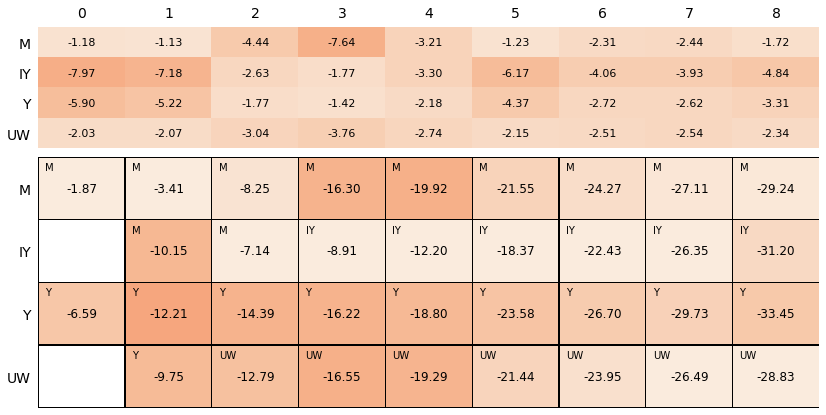

In [34]:
trellis3.plot_trellis(plot_obs_probs=True,plot_backptrs=True,
                plot_norm=True,vmin=-50.,vmax=0,cmapf=None,fmt=".2f",figsize=(14,7))

#### STEP3: Compute a Trellis for the model with Augmented features your test sample

In [35]:
hmm4.print_model()


HMM STATE MODEL



,M,IY,Y,UW
Pinit(.),-0.693,-89.801,-0.693,-89.801


,M,IY,Y,UW
P(M|.),-0.405,-89.801,-89.801,-89.801
P(IY|.),-1.099,0.000,-89.801,-89.801
P(Y|.),-89.801,-89.801,-0.405,-89.801
P(UW|.),-89.801,-89.801,-1.099,0.000



OBSERVATION MODEL

Means
[[ 2.5        -1.55555556]
 [ 5.          4.25      ]
 [ 2.5         3.        ]
 [ 5.         -2.625     ]]
Variance
[[1.44444446 1.52469137]
 [5.56250001 2.93750001]
 [1.44444446 2.72222223]
 [5.56250001 8.67187501]]


In [36]:
trellis4 = libhmm.Trellis(hmm4)
trellis4.viterbi_pass(MY_Xa)
trellis4.print_trellis(what=['obs_probs','probs','backpointers'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8
M,-2.886,-2.363,-5.560,-9.098,-6.789,-3.674,-4.373,-5.393,-4.361
IY,-9.874,-9.831,-5.079,-3.745,-5.076,-7.971,-5.896,-5.707,-6.633
Y,-7.604,-6.454,-2.889,-2.875,-5.760,-6.821,-4.777,-5.578,-5.947
UW,-3.928,-4.714,-5.484,-5.737,-4.521,-3.951,-4.347,-4.321,-4.127



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8
M,-3.579,-6.347,-12.313,-21.816,-29.010,-33.090,-37.868,-43.666,-48.433
IY,-99.675,-14.508,-12.525,-16.270,-21.346,-29.317,-35.213,-40.920,-47.552
Y,-8.297,-15.156,-18.451,-21.732,-27.898,-35.125,-40.307,-46.290,-52.643
UW,-93.729,-14.110,-19.594,-25.287,-27.352,-31.303,-35.650,-39.971,-44.098



Backpointers



,0,1,2,3,4,5,6,7,8
M,0,0,0,0,0,0,0,0,0
IY,1,0,0,1,1,1,1,1,1
Y,2,2,2,2,2,2,2,2,2
UW,3,2,3,2,2,3,3,3,3


### Questions
    
- Verify by hand column 4 (label '3') of the trellis computed with the delta features.  Simplify your computations by setting very small probabilities to zero.  Would it be easier to do so using probabilities instead of log-probs ?
- The Viterbi alignment obtained is different in Trellis3 vs. Trellis4.  Which one would you believe more and why ?  Will this depend on the test sample ?
- The scores obtained in the trellis with 'augmented features' are significantly lower than for 'delta features' alone.  Is this an indication that the 'augmented features' are actually worse than the 'delta features' alone ?   Is your answer generic or specific to the underlying models or specific to the applied techniques ?
- What would you change to the trellis's above if you knew that one of the words was 10x more likely than the other ?  Woud this have changed the recognition result ? 